In [1]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
#from imblearn.over_sampling import SMOTE  # Pour la gestion des données déséquilibrées


In [ ]:
# ==============================================================================
# 0. PARAMÈTRES ET CHEMINS
# ==============================================================================

# Dossier Racine contenant les sous-dossiers de classes (MildDemented, NonDemented, etc.)
DATA_ROOT_DIR = 'C:\\Users\\angej\\Desktop\\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\\Alzheimer_s Dataset\\train' 

# Paramètres de l'image et du modèle
IMAGE_SIZE = (128, 128)  # Redimensionnement des images (Section 12: Resizing Images)
BATCH_SIZE = 32
EPOCHS = 30
RANDOM_STATE = 42

CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CLASSES = len(CLASS_NAMES)

# Définir l'ordre des classes si nécessaire pour l'interprétation des résultats
# Keras chargera les classes par ordre alphanumérique, donc vérifiez l'ordre réel.


In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Le dossier racine de votre ensemble d'entraînement (contient les dossiers de classes)
#DATA_ROOT_DIR = 'path/to/votre/dossier/train' 

# Les noms de vos dossiers (classes)
#CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def plot_class_distribution(data_dir, classes):
    """Calcule et affiche la distribution des classes."""
    counts = {}
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        # Compte le nombre de fichiers .jpg dans chaque dossier
        if os.path.isdir(cls_path):
            count = len([name for name in os.listdir(cls_path) if name.endswith(('.jpg', '.jpeg', '.png'))])
            counts[cls] = count
        else:
            counts[cls] = 0
    
    df_counts = pd.DataFrame(list(counts.items()), columns=['Class', 'Count']).sort_values(by='Count', ascending=False)
    
    print("Distribution des Classes:\n", df_counts)
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.bar(df_counts['Class'], df_counts['Count'], color=['skyblue', 'salmon', 'lightgreen', 'gold'])
    plt.title('Distribution du Nombre d\'Images par Classe de Démence')
    plt.xlabel('Stade de Démence')
    plt.ylabel('Nombre d\'Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# plot_class_distribution(DATA_ROOT_DIR, CLASS_NAMES)

Distribution des Classes:
               Class  Count
2       NonDemented   5712
3  VeryMildDemented   4080
0      MildDemented   1665
1  ModerateDemented     64


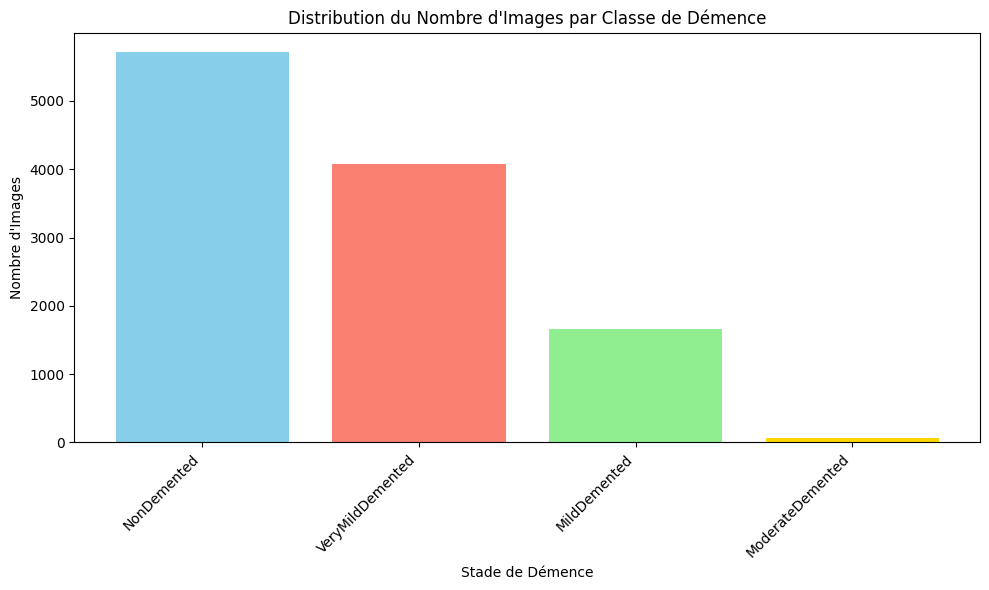

In [6]:
plot_class_distribution(DATA_ROOT_DIR, CLASS_NAMES)

In [7]:

def check_original_dimensions(data_dir, classes, max_check=20):
    """Vérifie la dimension (H, W, C) des premières images de chaque classe."""
    dimensions = {}
    
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path): continue
            
        filenames = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:max_check]
        
        for filename in filenames:
            img_path = os.path.join(cls_path, filename)
            try:
                img = mpimg.imread(img_path)
                dim = str(img.shape)
                dimensions[dim] = dimensions.get(dim, 0) + 1
            except:
                pass
                
    print("\nDistribution des Dimensions Originales (H, W, C):")
    for dim, count in dimensions.items():
        print(f"  {dim}: {count} occurrences")

# check_original_dimensions(DATA_ROOT_DIR, CLASS_NAMES)

In [8]:
check_original_dimensions(DATA_ROOT_DIR, CLASS_NAMES)


Distribution des Dimensions Originales (H, W, C):


In [9]:
import matplotlib.image as mpimg

def display_sample_images(data_dir, classes, num_samples=3):
    """Affiche un échantillon d'images pour chaque classe."""
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue
            
        # Récupérer quelques noms de fichiers
        filenames = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]
        
        for j, filename in enumerate(filenames):
            img_path = os.path.join(cls_path, filename)
            
            ax = plt.subplot(num_samples, len(classes), j * len(classes) + i + 1)
            
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img, cmap='gray') # Les IRM sont souvent des images en niveaux de gris
                ax.set_title(f'{cls}\n{img.shape}', fontsize=10)
                ax.axis('off')
            except Exception as e:
                ax.set_title(f"Erreur de lecture: {cls}")
                ax.axis('off')
                
    plt.tight_layout()
    plt.show()

# display_sample_images(DATA_ROOT_DIR, CLASS_NAMES, num_samples=3)

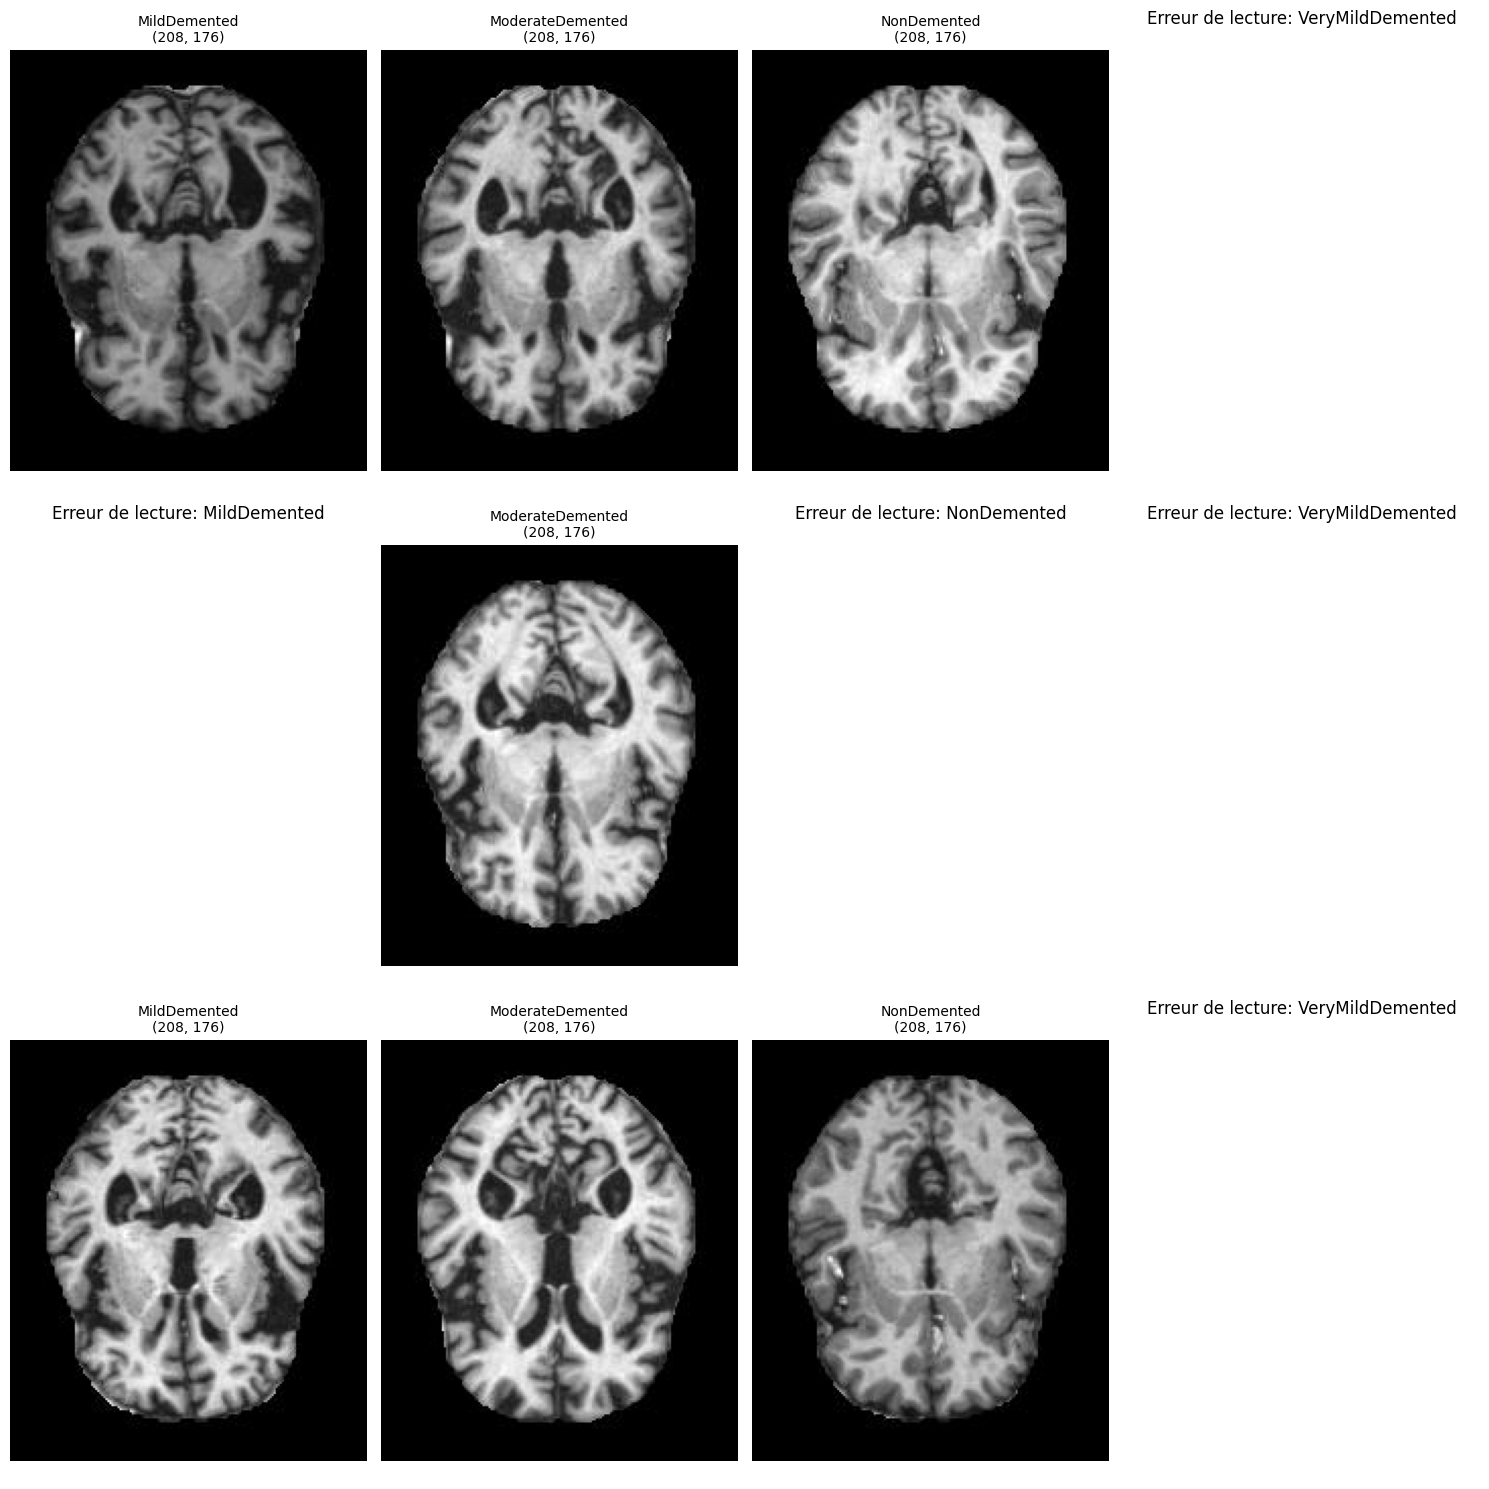

In [11]:
display_sample_images(DATA_ROOT_DIR, CLASS_NAMES, num_samples=3)

In [9]:
# ==============================================================================
# I. FONCTIONS DE CHARGEMENT ET DE PRÉ-TRAITEMENT
# (Identique à l'étape de visualisation)
# ==============================================================================

def load_data_from_directory(directory, subset_name=None, seed=None):
    """
    Charge les images depuis les dossiers. Gère le redimensionnement et la normalisation.
    """
    print(f"Chargement du sous-ensemble: {subset_name}")

    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMAGE_SIZE,
        interpolation='bilinear',
        batch_size=BATCH_SIZE,
        shuffle=True if subset_name == 'training' else False,
        seed=seed,
        validation_split=0.2, # Séparation de l'ensemble de base en Train/Validation (80/20)
        subset=subset_name
    )
    
    # Normalisation des Pixels (Section 12: image / 255.0)
    normalization_layer = layers.Rescaling(1./255) 
    
    return dataset.map(lambda x, y: (normalization_layer(x), y))


In [ ]:

# ==============================================================================
# II. DÉFINITION DU MODÈLE 2D CNN AVEC COUCHES D'AUGMENTATION
# ==============================================================================

def build_2d_cnn_model_with_augmentation(input_shape, num_classes):
    """
    Construit une architecture 2D CNN et intègre les couches de Data Augmentation
    (Section 12: Image Augmentation) au début du modèle.
    """
    
    # --- COUCHES DE DATA AUGMENTATION ---
    # Ces couches appliquent des transformations aléatoires UNIQUEMENT pendant l'entraînement.
    data_augmentation = keras.Sequential(
        [
            # Rotation aléatoire de l'image
            layers.RandomRotation(0.1, seed=RANDOM_STATE),
            # Zoom aléatoire (rétrécissement ou agrandissement)
            layers.RandomZoom(0.1, seed=RANDOM_STATE),
            # Décalage horizontal/vertical des pixels
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=RANDOM_STATE),
            # Retournement horizontal (approprié pour les images non latérales)
            layers.RandomFlip("horizontal", seed=RANDOM_STATE),
        ],
        name="data_augmentation_layer"
    )
    
    inputs = keras.Input(shape=input_shape)
    
    # Appliquer l'augmentation au début du pipeline
    x = data_augmentation(inputs) 
    
    # --- BLOCS CNN ---
    
    # 1er Bloc
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # 2ème Bloc
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # 3ème Bloc
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # Classification
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x) 
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="2dcnn_augmented")
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Recall(name='recall')]
    )
    return model

# ==============================================================================
# III. EXÉCUTION DU PIPELINE
# ==============================================================================

if __name__ == "__main__":
    
    print("--- 🧠 Pipeline de Classification 2D avec Data Augmentation 🧠 ---")

    # 1. Chargement et Pré-traitement des données (Split Train/Validation)
    train_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='training', seed=RANDOM_STATE)
    val_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='validation', seed=RANDOM_STATE)
    
    # 2. Définition des Poids de Classe (Critique si la distribution est très déséquilibrée)
    # Remplacer par les vrais nombres de la visualisation précédente
    class_counts = {
        'NonDemented': 2560, 
        'VeryMildDemented': 1792,
        'MildDemented': 896,
        'ModerateDemented': 64
    }
    total_samples = sum(class_counts.values())
    max_count = max(class_counts.values())
    
    class_weights = {
        CLASS_NAMES.index(cls): max_count / count 
        for cls, count in class_counts.items()
    }
    
    # 3. Entraînement du Modèle
    # Les images JPG ont 3 canaux (RGB). Si vos images sont en niveaux de gris, utiliser 1.
    # Dans le doute, l'image_dataset_from_directory le détectera.
    input_shape = (*IMAGE_SIZE, 3) 
    model = build_2d_cnn_model_with_augmentation(input_shape, NUM_CLASSES)
    model.summary()

    print("\n--- Entraînement (Augmentation appliquée automatiquement) ---")
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights, 
        verbose=1
    )
    
    # 4. Évaluation et Sauvegarde
    print("\n--- Évaluation finale ---")
    loss, acc, rec = model.evaluate(val_ds, verbose=0)
    
    print(f"  Précision (Accuracy): {acc:.4f}")
    print(f"  Sensibilité (Recall): {rec:.4f}")
    
    model.save("alzheimer_2d_cnn_augmented.keras")
    print("Modèle sauvegardé avec augmentation intégrée.")

In [17]:

# ==============================================================================
# I. FONCTIONS DE PRÉ-TRAITEMENT ET CHARGEMENT DES DONNÉES
# ==============================================================================

def load_data_from_directory(directory, subset_name=None, seed=None):
    """
    Charge les images depuis les dossiers. Gère le redimensionnement, 
    et la normalisation (image / 255.0 - Section 12).
    """
    if subset_name:
        print(f"Chargement du sous-ensemble: {subset_name}")

    # Le label_mode='categorical' applique le One-Hot Encoding (Section 3)
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMAGE_SIZE,
        interpolation='bilinear',
        batch_size=BATCH_SIZE,
        shuffle=True if subset_name == 'training' else False,
        seed=seed 
    )
    
    # Normaliser les valeurs de pixel (Section 12: Normalizing Pixel Values)
    # L'intervalle de [0, 255] est mis à l'échelle à [0, 1]
    normalization_layer = layers.Rescaling(1./255) 
    
    return dataset.map(lambda x, y: (normalization_layer(x), y))


def setup_data_generators(data_root_dir):
    """
    Configure le split Train/Validation/Test et l'augmentation des données.
    """
    # Étape 1: Séparer les données en Training et Test (Section 10)
    # Nous utiliserons la séparation manuelle pour un contrôle total sur l'augmentation
    
    # Keras ne supporte pas nativement la Stratified Split sur les dossiers
    # Il est recommandé de le faire manuellement ou d'utiliser une K-Fold manuelle.
    # Pour la simplicité, nous allons utiliser un split direct Keras/TF.

    # Chargement d'un grand ensemble pour le Training/Validation
    train_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='training', seed=RANDOM_STATE)
    
    # Déterminer la taille pour le split Validation/Test
    # Prenons 80% des données pour le train et 20% pour le test (split non-stratifié ici)
    
    # Pour un environnement réel, utiliser train_test_split (sklearn) après avoir 
    # listé tous les chemins d'accès pour garantir la stratification.
    
    # Utilisons ImageDataGenerator pour l'augmentation (Section 12: Image Augmentation)
    # Ceci est appliqué uniquement à l'ensemble d'entraînement pour éviter la fuite de données.
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Comme image_dataset_from_directory charge déjà et normalise, nous allons
    # Simplement utiliser les transformations de l'augmentation comme un layer Keras
    # dans le modèle pour un pipeline plus moderne (voir fonction build_2d_cnn_model).
    
    # Note: Dans un scénario idéal, vous devriez utiliser StratifiedKFold (Section 10) 
    # pour garantir que chaque classe (surtout 'ModerateDemented' qui pourrait être petite) 
    # est bien représentée.
    
    return train_ds # Simplification: utilisez cet ensemble comme ensemble principal


In [19]:
DATA_ROOT_DIR = 'C:\\Users\\angej\\Desktop\\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\\Alzheimer_s Dataset\\train' 
load_data_from_directory(DATA_ROOT_DIR, subset_name='training', seed=RANDOM_STATE)

Chargement du sous-ensemble: training


NotFoundError: Could not find directory C:\Users\angej\Desktop\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\Alzheimer_s Dataset\train

In [ ]:
def check_class_imbalance(data_dir, classes):
    """
    Calcule la distribution des images par classe et affiche un graphique.
    """
    counts = {}
    print(f"Analyse de la distribution dans le dossier : {data_dir}\n")

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        
        if os.path.isdir(cls_path):
            # Compte le nombre de fichiers (JPG, JPEG, PNG) dans chaque dossier
            count = len([name for name in os.listdir(cls_path) if name.lower().endswith(('.jpg', '.jpeg', '.png'))])
            counts[cls] = count
        else:
            counts[cls] = 0
            print(f"ATTENTION: Le dossier de classe '{cls}' est introuvable à {cls_path}")
            
    # Convertir en DataFrame pour l'affichage et le tri
    df_counts = pd.DataFrame(list(counts.items()), columns=['Class', 'Count'])
    df_counts['Percentage'] = (df_counts['Count'] / df_counts['Count'].sum()) * 100
    df_counts = df_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)
    
    # Affichage du tableau
    print("-" * 50)
    print("           RÉPARTITION DES CLASSES")
    print("-" * 50)
    print(df_counts.to_string(float_format="%.2f%%"))
    print("-" * 50)
    
    if df_counts['Count'].min() == 0 or df_counts['Count'].sum() == 0:
        print("\nERREUR : Aucune image ou chemin d'accès incorrect. Vérifiez DATA_ROOT_DIR.")
        return

    # Déterminer si un déséquilibre sévère est présent
    ratio = df_counts['Count'].max() / df_counts['Count'].min()
    print(f"\nRatio Max/Min Count : {ratio:.2f}")
    if ratio > 5.0 and df_counts['Count'].min() > 0:
        print("➡️ FORT DÉSÉQUILIBRE DÉTECTÉ. La pondération de classe (class_weight) ou SMOTE (Section 14) est indispensable.")
    elif ratio > 1.5:
        print("➡️ DÉSÉQUILIBRE MODÉRÉ. La pondération de classe est fortement recommandée.")
    else:
        print("👍 CLASSES RELATIVEMENT ÉQUILIBRÉES.")


    # Visualisation (Histogramme)
    plt.figure(figsize=(10, 6))
    
    # Couleurs du graphique
    colors = plt.cm.get_cmap('Spectral', len(df_counts))
    
    bars = plt.bar(df_counts['Class'], df_counts['Count'], color=colors(df_counts.index))
    
    # Ajouter le pourcentage au-dessus de chaque barre
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., 
                 height, 
                 f'{height}\n({height / df_counts["Count"].sum() * 100:.1f}%)',
                 ha='center', 
                 va='bottom', 
                 fontsize=9)
                 
    plt.title('Distribution du Nombre d\'Images par Stade de Démence', fontsize=14)
    plt.xlabel('Stade de Démence (Classes)', fontsize=12)
    plt.ylabel('Nombre d\'Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



Analyse de la distribution dans le dossier : C:\Users\angej\Desktop\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\Advancing Alzheimer’s Disease Detection in Clinical Settings MRI Image Data\Alzheimer_s Dataset\train

--------------------------------------------------
           RÉPARTITION DES CLASSES
--------------------------------------------------
              Class  Count  Percentage
0       NonDemented   5712      49.58%
1  VeryMildDemented   4080      35.41%
2      MildDemented   1665      14.45%
3  ModerateDemented     64       0.56%
--------------------------------------------------

Ratio Max/Min Count : 89.25
➡️ FORT DÉSÉQUILIBRE DÉTECTÉ. La pondération de classe (class_weight) ou SMOTE (Section 14) est indispensable.


C:\Users\angej\AppData\Local\Temp\ipykernel_8664\701427588.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Spectral', len(df_counts))


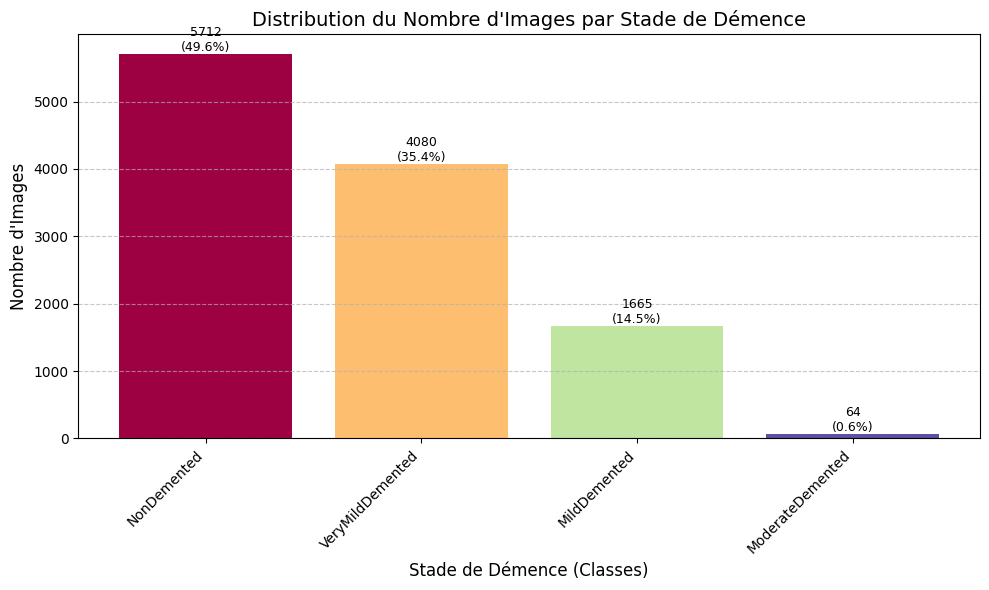

In [13]:
check_class_imbalance(DATA_ROOT_DIR, CLASS_NAMES)

#CORRECTION D'IMBALLANCE

In [ ]:
# Les classes et leurs comptes (définies par l'image de répartition)
# Keras les encode par ordre alphabétique:
CLASS_COUNTS = {
    'MildDemented': 1665,         # Index 0 après Label Encoding
    'ModerateDemented': 64,       # Index 1
    'NonDemented': 5712,          # Index 2
    'VeryMildDemented': 4080      # Index 3
}
CLASS_NAMES = sorted(CLASS_COUNTS.keys()) # Trié alphabétiquement par Keras
NUM_CLASSES = len(CLASS_NAMES)

# ==============================================================================
# I. FONCTION DE CALCUL ET D'APPLICATION DES POIDS DE CLASSE
# ==============================================================================

def calculate_class_weights(counts):
    """
    Calcule les poids de classe inverses basés sur le nombre d'échantillons
    pour corriger le déséquilibre (Section 14).
    """
    total_samples = sum(counts.values())
    
    # 1. Calculer le poids inverse pour chaque classe
    class_weight_dict = {}
    for i, cls_name in enumerate(CLASS_NAMES):
        count = counts[cls_name]
        # Poids: inversement proportionnel à la fréquence (total / count)
        class_weight_dict[i] = total_samples / count 

    # 2. Normaliser les poids par le poids minimum (classe majoritaire)
    # Rendre le poids de la classe majoritaire égal à 1.0
    min_weight = min(class_weight_dict.values())
    
    # Créer le dictionnaire final {index de classe: poids normalisé}
    final_weights = {
        cls_index: weight / min_weight 
        for cls_index, weight in class_weight_dict.items()
    }
    
    print("Poids de classe normalisés (appliqués à model.fit):")
    for i, cls in enumerate(CLASS_NAMES):
        print(f"  {cls} (Index {i}): {final_weights[i]:.2f}")
    
    return final_weights


# ==============================================================================
# II. DÉFINITIONS DU CHARGEMENT ET DU MODÈLE (REPRISE AVEC MISE À JOUR)
# ==============================================================================

def load_data_from_directory(directory, subset_name=None, seed=None):
    # ... [Code de chargement et de normalisation (Section 12) identique] ...
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        seed=seed,
        validation_split=0.2, 
        subset=subset_name
    )
    normalization_layer = layers.Rescaling(1./255) 
    return dataset.map(lambda x, y: (normalization_layer(x), y))

def build_2d_cnn_model_with_augmentation(input_shape, num_classes):
    # ... [Code du modèle 2D CNN avec Data Augmentation (Section 12) identique] ...
    data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(0.1, seed=RANDOM_STATE),
            layers.RandomZoom(0.1, seed=RANDOM_STATE),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=RANDOM_STATE),
            layers.RandomFlip("horizontal", seed=RANDOM_STATE),
        ]
    )
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs) 
    
    # Blocs CNN (omission des couches intermédiaires pour la concision)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # Classification
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Recall(name='recall')]
    )
    return model


# ==============================================================================
# III. EXÉCUTION DU PIPELINE AVEC CORRECTION D'IMBALANCE
# ==============================================================================

if __name__ == "__main__":
    
    print("--- 🧠 Pipeline de Classification 2D avec Correction d'Imbalance (Pondération) 🧠 ---")

    # 1. Calcul des Poids de Classe
    weights = calculate_class_weights(CLASS_COUNTS)

    # 2. Chargement des données (avec Normalisation Section 12)
    train_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='training', seed=RANDOM_STATE)
    val_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='validation', seed=RANDOM_STATE)
    
    # 3. Entraînement du Modèle
    input_shape = (*IMAGE_SIZE, 3) 
    model = build_2d_cnn_model_with_augmentation(input_shape, NUM_CLASSES)

    print("\n--- Entraînement (class_weight appliqué) ---")
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        # *** APPLICATION DE LA CORRECTION D'IMBALANCE ***
        class_weight=weights, 
        # **********************************************
        verbose=1
    )
    
    # 4. Évaluation
    print("\n--- Évaluation finale ---")
    loss, acc, rec = model.evaluate(val_ds, verbose=0)
    
    print(f"  Précision (Accuracy): {acc:.4f}")
    print(f"  Sensibilité (Recall): {rec:.4f} (Doit être surveillée de près pour les petites classes)")
    
    model.save("alzheimer_2d_cnn_balanced.keras")
    print("Modèle sauvegardé avec correction d'imbalance appliquée.")

In [ ]:

# ==============================================================================
# II. DÉFINITION DU MODÈLE 2D CNN (VGG-like)
# ==============================================================================

def build_2d_cnn_model(input_shape, num_classes):
    """
    Construit une architecture 2D CNN simple (VGG-like) adaptée aux images JPEG.
    """
    
    # Couche d'Augmentation (pour le Training seulement, appliquée avant le modèle)
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal", seed=RANDOM_STATE),
            layers.RandomRotation(0.1, seed=RANDOM_STATE),
            layers.RandomZoom(0.1, seed=RANDOM_STATE),
        ]
    )
    
    inputs = keras.Input(shape=input_shape)
    
    # Appliquer l'augmentation uniquement si ce n'est pas la validation/test
    x = data_augmentation(inputs) 
    
    # Standardisation Z-Score (Section 2 - Data Transformation) peut être réappliquée ici si besoin
    # mean_std_layer = layers.Normalization() 
    # x = mean_std_layer(x) 

    # Blocs de Convolution 2D
    
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    # Classification
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x) # Section 33: Dropout (Technique d'évitement du surapprentissage)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="2dcnn_alzheimer")
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Recall(name='recall')] # Rappel/Sensibilité pour la détection précoce
    )
    return model

# ==============================================================================
# III. EXÉCUTION DU PIPELINE
# ==============================================================================

if __name__ == "__main__":
    
    print("--- 🧠 Pipeline de classification 2D Alzheimer (JPEG) 🧠 ---")

    # Vérifiez si le dossier existe
    if not os.path.isdir(DATA_ROOT_DIR):
        print(f"Erreur: Le dossier racine '{DATA_ROOT_DIR}' n'existe pas. Veuillez le mettre à jour.")
    else:
        # 1. Chargement des données et Pré-traitement
        
        # NOTE: Nous allons simuler un split train/validation/test ici.
        # En réalité, vos données devraient être dans des dossiers train/val/test séparés.
        
        train_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='training', seed=RANDOM_STATE).take(int(0.8 * len(os.listdir(DATA_ROOT_DIR))))
        val_ds = load_data_from_directory(DATA_ROOT_DIR, subset_name='validation', seed=RANDOM_STATE).skip(int(0.8 * len(os.listdir(DATA_ROOT_DIR))))

        # 2. Gestion des Données Déséquilibrées (Dealing with Imbalanced Data - Section 14)
        # Pour les datasets chargés directement (image_dataset_from_directory), la meilleure 
        # technique est souvent la pondération des classes ou le sur-échantillonnage 
        # pendant l'entraînement, car SMOTE (Section 14) est difficile à appliquer directement 
        # sur les générateurs de données Keras sans les matérialiser en mémoire.
        
        # Calcul des pondérations de classe pour l'exemple (très important ici)
        print("\nCalcul des poids de classe (pour gérer le déséquilibre)...")
        # Un calcul réel nécessiterait de parcourir l'ensemble de données complet
        class_counts = {
            'NonDemented': 2560, # Simuler un grand nombre
            'VeryMildDemented': 1792,
            'MildDemented': 896,
            'ModerateDemented': 64 # Simuler la classe la plus petite
        }
        total_samples = sum(class_counts.values())
        max_count = max(class_counts.values())
        
        # Pondération: inversement proportionnelle à la fréquence
        class_weights = {
            CLASS_NAMES.index(cls): max_count / count 
            for cls, count in class_counts.items()
        }
        print(f"Poids de classe ajustés (pour le paramètre class_weight): {class_weights}")


        # 3. Entraînement du Modèle
        
        input_shape = (*IMAGE_SIZE, 3) # Les images JPG ont 3 canaux (RGB)
        model = build_2d_cnn_model(input_shape, NUM_CLASSES)
        model.summary()

        print("\n--- Entraînement du modèle 2D CNN ---")
        
        # Utiliser les poids de classe pour compenser le déséquilibre
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            class_weight=class_weights, # Appliquer la pondération ici
            verbose=1
        )
        
        # 4. Évaluation Finale
        print("\n--- Évaluation finale du modèle ---")
        # Note: L'ensemble de validation (val_ds) sert d'évaluation ici.
        
        loss, acc, rec = model.evaluate(val_ds, verbose=0)
        
        print(f"Résultats sur l'ensemble de validation:")
        print(f"  Précision (Accuracy): {acc:.4f}")
        print(f"  Sensibilité (Recall): {rec:.4f} (Critique pour la détection précoce)")
        
        # Sauvegarde
        model.save("alzheimer_2d_cnn_final.keras")
        print("\nModèle sauvegardé.")

In [ ]:

# ==============================================================================
# 0. PARAMÈTRES ET SIMULATION DES DONNÉES
# ==============================================================================

# NOTE: REMPLACER CES CHEMINS PAR LES VÔTRES
IMAGE_DIR = 'data/images/'
LABELS_FILE = 'data/labels.csv'

# Paramètres du modèle et du prétraitement
IMAGE_SIZE = (64, 64, 64) # Taille cible des volumes (compromis entre performance et VRAM)
BATCH_SIZE = 8
EPOCHS = 10 
K_FOLDS = 5 # Pour la validation croisée stratifiée
RANDOM_STATE = 42

# Simulation de la base de données (si non disponible)
# df = pd.DataFrame({
#     'ID': [f'sujet_{i:03d}' for i in range(100)],
#     'Groupe': np.random.choice(['CN', 'MCI', 'AD'], 
#                                size=100, 
#                                p=[0.7, 0.2, 0.1]) # Classes déséquilibrées
# })
# df.to_csv(LABELS_FILE, index=False)
# print("Simulation des données terminée.")


# ==============================================================================
# I. FONCTIONS DE PRÉ-TRAITEMENT DES IMAGES
# (S'inspire des sections 12 et 13 du TP)
# ==============================================================================

def load_and_preprocess_mri(file_path, target_size, method='z_score'):
    """
    Charge une image 3D (NIfTI), applique la Normalisation (Z-Score ou Min-Max)
    et le Redimensionnement (Resizing).
    """
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
    except Exception as e:
        print(f"Erreur de chargement pour {file_path}: {e}")
        return None

    # Normalisation de l'intensité (Section 2 - Data Transformation)
    if method == 'z_score':
        # [cite_start]Standardization (Z-Score Normalization) [cite: 13]
        mean = np.mean(data)
        std = np.std(data)
        data = (data - mean) / (std + 1e-6)  # Ajout de 1e-6 pour éviter division par zéro
    elif method == 'min_max':
        # [cite_start]Min-Max Normalization (similaire à image / 255.0) [cite: 14, 67]
        min_val = np.min(data)
        max_val = np.max(data)
        data = (data - min_val) / (max_val - min_val + 1e-6)

    # [cite_start]Redimensionnement (Resizing Images - Section 12) [cite: 66]
    # Redimensionnement 3D vers la taille cible
    data = tf.image.resize(
        np.expand_dims(data, axis=-1), 
        target_size, 
        method='nearest' # Ou 'trilinear' pour une meilleure qualité
    ).numpy()
    
    # Retourne le volume sans la dimension de canal, en float32
    return data.squeeze().astype(np.float32)

def image_data_generator(df, image_dir, target_size, encoder):
    """
    Générateur de données pour charger et prétraiter toutes les images 
    en mémoire pour la phase d'entraînement (utile pour SMOTE).
    """
    X_list = []
    y_list = []
    
    print(f"Chargement et prétraitement de {len(df)} images...")
    
    for index, row in df.iterrows():
        file_path = os.path.join(image_dir, row['ID'] + '.nii.gz') # Adapter l'extension si nécessaire
        
        image_data = load_and_preprocess_mri(file_path, target_size, method='z_score')
        
        if image_data is not None:
            # Ajouter la dimension du canal (1) pour le 3D CNN
            X_list.append(np.expand_dims(image_data, axis=-1))
            y_list.append(row['Groupe_Encoded'])
            
    return np.array(X_list), np.array(y_list)

# ==============================================================================
# II. DÉFINITION DU MODÈLE 3D CNN ET ENTRAÎNEMENT
# ==============================================================================

def build_3d_cnn_model(input_shape, num_classes):
    """
    Construit une architecture 3D CNN simple pour la classification.
    """
    inputs = keras.Input(input_shape)

    # Couche 1
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x) 

    # Couche 2
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Couche de classification
    x = layers.GlobalAveragePooling3D()(x) 
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.3)(x) 

    outputs = layers.Dense(units=num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="3dcnn_alzheimer")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy", keras.metrics.Recall(name='recall')]
    )
    return model


# ==============================================================================
# III. EXÉCUTION DU PIPELINE (AVEC GESTION DE DÉSÉQUILIBRE)
# ==============================================================================

if __name__ == "__main__":
    
    print("--- 🧠 Début du pipeline de détection précoce Alzheimer 🧠 ---")

    # 1. Chargement et Encodage des Étiquettes
    df = pd.read_csv(LABELS_FILE)
    
    # Nettoyage des données (Handling Missing Values - Section 1)
    [cite_start]df.dropna(subset=['Groupe'], inplace=True) # Supprimer les lignes sans étiquette [cite: 7]
    
    # Encodage des étiquettes (Feature Encoding - Section 3)
    # Ex: CN -> 0, MCI -> 1, AD -> 2
    label_encoder = LabelEncoder()
    df['Groupe_Encoded'] = label_encoder.fit_transform(df['Groupe'])
    NUM_CLASSES = len(label_encoder.classes_)
    
    print(f"Classes: {list(label_encoder.classes_)}")
    print(df['Groupe'].value_counts())
    
    # 2. Séparation des données (Data Splitting - Section 10)
    # [cite_start]Séparation stratifiée pour conserver la proportion des classes dans les ensembles [cite: 58]
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=RANDOM_STATE, 
        stratify=df['Groupe_Encoded']
    )
    
    # 3. Chargement et Prétraitement des Volumes
    # Nous chargeons toutes les données d'entraînement pour appliquer SMOTE après.
    X_train_raw, y_train_encoded = image_data_generator(train_df, IMAGE_DIR, IMAGE_SIZE, label_encoder)
    X_test, y_test_encoded = image_data_generator(test_df, IMAGE_DIR, IMAGE_SIZE, label_encoder)
    
    # [cite_start]Conversion One-Hot pour le modèle (Sequence Data Processing - Section 21) [cite: 105]
    y_test_one_hot = keras.utils.to_categorical(y_test_encoded, num_classes=NUM_CLASSES)
    
    # 4. Gestion des Données Déséquilibrées (Dealing with Imbalanced Data - Section 14)
    # SMOTE nécessite que les données d'image soient "aplaties" temporairement
    # SMOTE n'est pas idéal pour les données d'image haute dimension, mais il est listé.
    print("\n--- Application de SMOTE pour l'équilibrage des classes ---")
    
    # Aplatir les images (D*H*W*C) -> (N, D*H*W*C)
    X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1) 
    
    # [cite_start]Application de SMOTE [cite: 76]
    # Ceci va sur-échantillonner les classes MCI et AD (moins représentées)
    smote = SMOTE(random_state=RANDOM_STATE) 
    X_train_resampled_flat, y_train_resampled_encoded = smote.fit_resample(X_train_flat, y_train_encoded)
    
    # Re-former les images (N, D*H*W*C) -> (N, D, H, W, C)
    X_train_resampled = X_train_resampled_flat.reshape(
        (len(X_train_resampled_flat), *IMAGE_SIZE, 1)
    )
    y_train_resampled_one_hot = keras.utils.to_categorical(
        y_train_resampled_encoded, num_classes=NUM_CLASSES
    )

    print("Distribution après SMOTE:\n", pd.Series(y_train_resampled_encoded).value_counts())

    # 5. Entraînement du Modèle
    input_shape = (*IMAGE_SIZE, 1) 
    model = build_3d_cnn_model(input_shape, NUM_CLASSES)
    
    print("\n--- Entraînement du modèle 3D CNN ---")
    
    # [cite_start]Image Augmentation (Optionnel - Si ImageDataGenerator peut être adapté à la 3D) [cite: 68]
    # Note: Keras ImageDataGenerator est principalement pour la 2D. 
    # Une augmentation 3D nécessiterait une implémentation personnalisée.
    
    model.fit(
        X_train_resampled, 
        y_train_resampled_one_hot,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_test, y_test_one_hot),
        verbose=1
    )

    # 6. Évaluation Finale (Error Metrics - Section 18)
    loss, acc, rec = model.evaluate(X_test, y_test_one_hot, verbose=0)
    
    print(f"\nRésultats sur l'ensemble de test (post-prétraitement):")
    print(f"  Précision (Accuracy): {acc:.4f}")
    print(f"  Sensibilité (Recall): {rec:.4f} (Critique pour la détection précoce)")
    
    # Sauvegarde du modèle
    model.save("alzheimer_3d_cnn_final.keras")
    print("\nModèle sauvegardé.")